In [2]:
# Import modules necessary for plotting
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
# Import other necessary modules for aggregates, dataframes, and date type conversions
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Instructions/Resources/hawaii.sqlite")

In [6]:
# Choosing to inspect the engine (alternate way of finding table names)
# Notice: inspect module also imported

inspector = inspect(engine)
inspector.get_table_names()

# Now use loops to further inspect tables and extract column names
# For 'measurement' table
measurement_columns = inspector.get_columns('measurement')
print("Measurement Columns:")
for column in measurement_columns:
    print(column['name'])

# Create space in between returned values for readability
print("\n")
print("------------------------------------------------------")
print("\n")

# For 'station' table
station_columns = inspector.get_columns('station')
print("Station Columns:")
for column in measurement_columns:
    print(column['name'])

Measurement Columns:
id
station
date
prcp
tobs


------------------------------------------------------


Station Columns:
id
station
date
prcp
tobs


In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table in their own seperate variable
# For 'measurements' table
measurements = Base.classes.measurement

# For 'station' table
stations = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set
most_recent_date = session.query(measurements.date).order_by(measurements.date.desc()).first()

# Print w/ 0th index because returned as tuple
print(most_recent_date[0])

2017-08-23


In [13]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database... 
# ..calculate the date one year from the last date in data set.
year_start_date = (dt.datetime.strptime(most_recent_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
year_start_date

# Perform a query to retrieve the date and precipitation scores
m_date_precip = (measurements.date, measurements.prcp)
precip_data = session.query(*m_date_precip).filter(measurements.date >= year_start_date).all()
precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_data, columns=["date", "precipitation"])
precip_data_df.set_index("date", inplace=True)
precip_data_df

# Better format column headers for readability and aethstetics 


# Sort the dataframe by date
precip_data_df =  precip_data_df.dropna()
precip_data_df = precip_data_df.sort_index()
precip_data_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


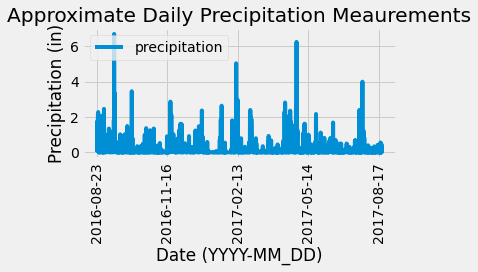

In [71]:
# Use Pandas Plotting with Matplotlib to plot the last year of precipitation data
ax = precip_data_df.plot(rot=90);
ax.set_title("Approximate Daily Precipitation Meaurements");
ax.set_xlabel("Date (YYYY-MM_DD)");
ax.set_ylabel("Precipitation (in)");
plt.tight_layout()
plt.show()
#plt.savefig("Instructions/Resources/Images/annual_precipitation_plot)

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [73]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(stations.id).count()
station_count

9

In [76]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurements.station, func.count(measurements.station)).group_by(measurements.station).\
                 order_by(func.count(measurements.station).desc()).all()
active_stations

# List most active station
most_active_station = active_stations[0][0]
most_active_station

'USC00519281'

In [85]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(*m_date_precip).filter(measurements.station == most_active_station).all()
most_active

# store queries for aggreate calculations in seperate varaibles
min = session.query(func.min(measurements.prcp)).all()
avg = session.query(func.avg(measurements.prcp)).all() 
max = session.query(func.max(measurements.prcp)).all() 

# Print out calculated aggreates
print("The aggregates found below are for the 'most active station', 'USC00519281'")
print(f"The 'MIN': {min[0][0]}")
print(f"The 'AVG': {round(avg[0][0], 2)}")
print(f"The 'MAX': {max[0][0]}")

The aggregates found below are for the 'most active station', 'USC00519281'
The 'MIN': 0.0
The 'AVG': 0.16
The 'MAX': 11.53


,Temperature
Date,
2016-08-23,81.0
2016-08-23,80.0
2016-08-23,77.0
2016-08-23,80.0
2016-08-23,76.0
...,...
2017-08-22,82.0
2017-08-23,82.0
2017-08-23,81.0


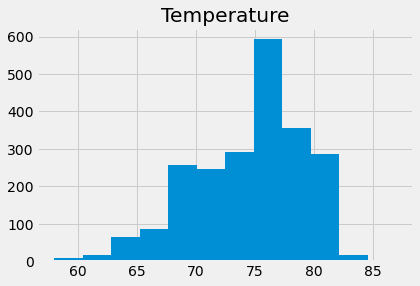

In [92]:
## Using the most active station id
## Query the last 12 months of temperature observation data for this station and plot the results as a histogram
m_date_tobs = (measurements.tobs, measurements.date)
annual_observation = session.query(*m_date_tobs).filter(measurements.date >= year_start_date).all()

# Creating dataframe with datay from query
annual_observation_df = pd.DataFrame(annual_observation, columns=("Temperature", "Date"))

# Droping NA values
annual_observation_df = annual_observation_df.dropna()

# Setting index to 'Date' column
annual_observation_df.set_index("Date", inplace=True)

# Sorting the index so it's in order by date
annual_observation_df = annual_observation_df.sort_index()

# Plotting data to histogram
annual_observation_df.hist(bins=12)
annual_observation_df

# Close session

In [93]:
# Close Session
session.close()